In [1]:
import sys
import pickle
from pprint import pprint
import time
import datetime

In [2]:
from qiskit import IBMQ

In [3]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='hirashi-jst')
backend = provider.get_backend("ibmq_montreal")
device = provider.backend.ibmq_montreal

In [4]:
sys.path.append("../../libs_bell/")
from lib_graph_states import adjacency_list_for_star_graph, list_to_matrix

In [5]:
vertex_list =  [ 8,
                11, 
                 5, 14,
                 9,  3, 13, 
                 2, 12, 16,
                 1, 15, 19,
                10,  0, 18, 20,
                  4, 22,  7, 21,
                 17, 25, 6, 23,
                 26, 24] # qubit layout
max_size = len(vertex_list) # largest graph size
Fs = [[0] for n in range(1, max_size + 1)] # subsets of focused vertices of graph size 1 to max_size
adj_lists = [adjacency_list_for_star_graph(n) for n in range(1, max_size + 1)] # adjacency list of graph size 1 to max_size
graphs = [list_to_matrix(adj_list) for adj_list in adj_lists] # adjacency matrix of graph size 1 to max_size
shots_per_circuit = 1 << 13 # shots per one execution

In [6]:
print("max_size:", max_size)
print("shots_per_circuit:", shots_per_circuit)

max_size: 27
shots_per_circuit: 8192


In [7]:
 # indicate how to connect qubits
order = [[0,1],
         [0,2],[1,3],
         [0,4],[2,5],[3,6],
         [5,7],[6,8],[3,9], 
         [7,10],[8,11],[9,12],
         [8,13],[10,14],[11,15],[12,16],
         [10,17],[12,18],[13,19],[15,20],
         [15,21],[18,22],[19,23],[20,24],
         [22,25],[24,26]]

In [8]:
from lib_graph_states import star_graph_state
qcs = [star_graph_state(size, order[:size-1]) for size in range(1, max_size+1)]
print(len(qcs), "qcs")

27 qcs


In [11]:
from lib_star_graphs import prepare_star_graph_qcs_list, execute_circuits

In [12]:
qcs_list, nums_divide_list, nums_meas_cal_list, initial_layouts_list = \
    prepare_star_graph_qcs_list(qcs, 
                                backend,
                                optimization_level=3,
                                initial_layouts=[vertex_list[:qc.num_qubits] for qc in qcs])
print("the number of graph state circuits is: ", len(qcs_list))

/Users/yangbo/opt/anaconda3/envs/qiskitenv/lib/python3.9/site-packages/qiskit/circuit/quantumcircuit.py:942: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)


the number of graph state circuits is:  152


In [ ]:
jobs = execute_circuits(qcs_list,
                        backend=backend,
                        shots=shots_per_circuit,
                        max_experiments=900,
                        optimization_level=0)
print(len(jobs), "jobs")
print("job_id:", jobs[0].job_id())

In [ ]:
dt_now = datetime.datetime.now()
job_ids_filename = "job_ids_" + dt_now.strftime('%Y%m%d_%H%M%S') + ".pkl"

In [ ]:
with open("./pkls/" + job_ids_filename, "wb") as f:
    pickle.dump([job.job_id() for job in jobs], f)

In [ ]:
with open("./pkls/" + "properties_" + dt_now.strftime('%Y%m%d_%H%M%S') + ".pkl", "wb") as f:
    pickle.dump(device.properties(), f)

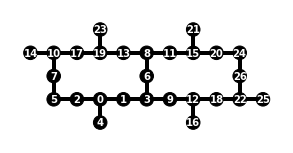

In [9]:
from qiskit.visualization import plot_circuit_layout
from qiskit import transpile
qc_on_device = transpile(qcs[-1], backend=backend, optimization_level=1, initial_layout=vertex_list)
plot_circuit_layout(qc_on_device, backend)